In [21]:
import os
import json
import sys

import sys
sys.path.append('../')  # Adding the core library

import maze
import importlib
importlib.reload(maze)

from maze.models import EfficientUNet

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# Dataset

Create a construct which loads the data based in COCO format, with additional heatmaps stored separately, with same naming as the source image.

In [22]:
class FishHeatmapDataset(Dataset):
    def __init__(self, annotation_json, image_dir, heatmap_dir,
                 img_transform=None, joint_transform=None):
        self.samples = []
        self.img_transform = img_transform
        self.joint_transform = joint_transform

        with open(annotation_json, 'r') as f:
            coco_data = json.load(f)

        for img_info in coco_data['images']:
            file_name = img_info['file_name']
            img_path = os.path.join(image_dir, file_name)
            heatmap_path = os.path.join(heatmap_dir, os.path.splitext(file_name)[0] + '.npy')

            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            heatmap = np.load(heatmap_path)  # float32, assumed [0, 1]

            self.samples.append((image, heatmap, file_name))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, heatmap, _ = self.samples[idx]

        # Convert image to PIL (color image)
        image = Image.fromarray(image)
        heatmap_tensor = torch.from_numpy(heatmap).unsqueeze(0)  # [1, H, W]

        # Apply same random transforms to both
        if self.joint_transform:
            seed = np.random.randint(0, 10000)
            torch.manual_seed(seed)
            image = self.joint_transform(image)
            torch.manual_seed(seed)
            heatmap_tensor = self.joint_transform(heatmap_tensor)

        # Individual transforms (image normalization etc.)
        if self.img_transform:
            image = self.img_transform(image)

        # Clamp heatmap just in case and ensure float32
        heatmap_tensor = heatmap_tensor.clamp(0, 1).float()

        return image, heatmap_tensor

In [23]:
joint_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])
joint_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Preload the data

We preload the data into DDR memory, as its not so big, and it speeds up the training process massively.

In [24]:
train_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_train.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    joint_transform=joint_train,
    img_transform=img_transform,
)

val_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_val.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    joint_transform=joint_val,
    img_transform=img_transform,
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

# Trainig

Let's setup our loss, optimizer etc.
1. **Loss**: we use Mean Squared Error (MSE) between predicted heatmap and target. It's simple and works well since both are smooth distribution
2. **Optimizer**: AdamW 
3. **LR scheduler**: ReduceLROnPlateau 

Later we run the training loop. 

In [25]:
# 1. Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 2. Initialize the model
model = EfficientUNet()

# Freeze first 3 stages of the encoder (enc1 to enc3)
for param in model.enc1.parameters():
    param.requires_grad = False
for param in model.enc2.parameters():
    param.requires_grad = False
for param in model.enc3.parameters():
    param.requires_grad = False

model = model.to(device)

# 3. Loss setup
mse_loss_fn = torch.nn.MSELoss()
alpha = 1.0

def get_centroid(heatmap):
    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w
    return x.float(), y.float()

def centroid_distance_loss(pred, target):
    x_pred, y_pred = get_centroid(pred)
    x_gt, y_gt = get_centroid(target)
    dist = torch.sqrt((x_pred - x_gt)**2 + (y_pred - y_gt)**2 + 1e-8)
    return dist.mean()

# 4. Optimizer & scheduler (unchanged)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


Using device: cuda


In [26]:
# 5. Training Loop Setup
epochs = 50
epoch_save_interval = 5

model_dir = '../data/models/efficientunet'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir, flush_secs=1)

best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for imgs, heatmaps in train_bar:
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)
        
        mse = mse_loss_fn(preds, heatmaps)
        cdist = centroid_distance_loss(preds, heatmaps)
        loss = mse + alpha * cdist

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        train_bar.set_postfix(mse=mse.item(), cdist=cdist.item())

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
    with torch.no_grad():
        for imgs, heatmaps in val_bar:
            imgs = imgs.to(device)
            heatmaps = heatmaps.to(device)

            preds = model(imgs)

            mse = mse_loss_fn(preds, heatmaps)
            cdist = centroid_distance_loss(preds, heatmaps)
            loss = mse + alpha * cdist

            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())
            val_bar.set_postfix(mse=mse.item(), cdist=cdist.item())

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

    # Save model checkpoint every N epochs
    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))

writer.close()

Epoch 1/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Loss = 109.5053, Val Loss = 148.6739


Epoch 2/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: Train Loss = 155.9818, Val Loss = 160.5398


Epoch 3/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3: Train Loss = 145.6926, Val Loss = 159.6035


Epoch 4/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4: Train Loss = 128.8454, Val Loss = 147.0789


Epoch 5/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: Train Loss = 106.5200, Val Loss = 69.8361


Epoch 6/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6: Train Loss = 92.0102, Val Loss = 43.6607


Epoch 7/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7: Train Loss = 82.7381, Val Loss = 23.4041


Epoch 8/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8: Train Loss = 76.3642, Val Loss = 16.9748


Epoch 9/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9: Train Loss = 70.7213, Val Loss = 12.1094


Epoch 10/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10: Train Loss = 62.5859, Val Loss = 10.5930


Epoch 11/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11: Train Loss = 60.7262, Val Loss = 9.5893


Epoch 12/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12: Train Loss = 57.3913, Val Loss = 9.3535


Epoch 13/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13: Train Loss = 54.2963, Val Loss = 9.1981


Epoch 14/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14: Train Loss = 52.5037, Val Loss = 8.9120


Epoch 15/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15: Train Loss = 48.7707, Val Loss = 8.4391


Epoch 16/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16: Train Loss = 48.1542, Val Loss = 8.1412


Epoch 17/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17: Train Loss = 42.5333, Val Loss = 7.7740


Epoch 18/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18: Train Loss = 43.0621, Val Loss = 7.8706


Epoch 19/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19: Train Loss = 40.6698, Val Loss = 7.6722


Epoch 20/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20: Train Loss = 38.6514, Val Loss = 7.6097


Epoch 21/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21: Train Loss = 37.9675, Val Loss = 7.5002


Epoch 22/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22: Train Loss = 34.2152, Val Loss = 7.3056


Epoch 23/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23: Train Loss = 32.8487, Val Loss = 7.7070


Epoch 24/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24: Train Loss = 31.9822, Val Loss = 7.6786


Epoch 25/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25: Train Loss = 31.3542, Val Loss = 7.2006


Epoch 26/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26: Train Loss = 30.2583, Val Loss = 7.8974


Epoch 27/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27: Train Loss = 28.4851, Val Loss = 8.0231


Epoch 28/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28: Train Loss = 28.1501, Val Loss = 7.6663


Epoch 29/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29: Train Loss = 26.5116, Val Loss = 7.9383


Epoch 30/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30: Train Loss = 26.0222, Val Loss = 8.0930


Epoch 31/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31: Train Loss = 25.8658, Val Loss = 8.2414


Epoch 32/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32: Train Loss = 26.0347, Val Loss = 8.3602


Epoch 33/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33: Train Loss = 25.5110, Val Loss = 8.0909


Epoch 34/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34: Train Loss = 25.5336, Val Loss = 8.1414


Epoch 35/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35: Train Loss = 26.0013, Val Loss = 8.0657


Epoch 36/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36: Train Loss = 25.9079, Val Loss = 8.2726


Epoch 37/50 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Model Validation

Now let's put model through numerous tests to see how well it performs.

In [27]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))

<All keys matched successfully>

In [28]:
results = []
total_distances = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for imgs, heatmaps in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)

        x_pred, y_pred = get_centroid(preds)
        x_gt, y_gt = get_centroid(heatmaps)

        x_pred = x_pred.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        x_gt = x_gt.cpu().numpy()
        y_gt = y_gt.cpu().numpy()

        for xp, yp, xg, yg in zip(x_pred, y_pred, x_gt, y_gt):
            dist = np.sqrt((xp - xg)**2 + (yp - yg)**2)
            total_distances.append(dist)
            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

        for i in range(imgs.size(0)):
            img = imgs[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            xp, yp = x_pred[i], y_pred[i]
            xg, yg = x_gt[i], y_gt[i]
            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
print(f"\nAverage centroid distance: {avg_dist:.2f} px")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


Average centroid distance: 7.30 px
Within 3px: 21.11%
Within 5px: 47.14%
Within 10px: 85.11%


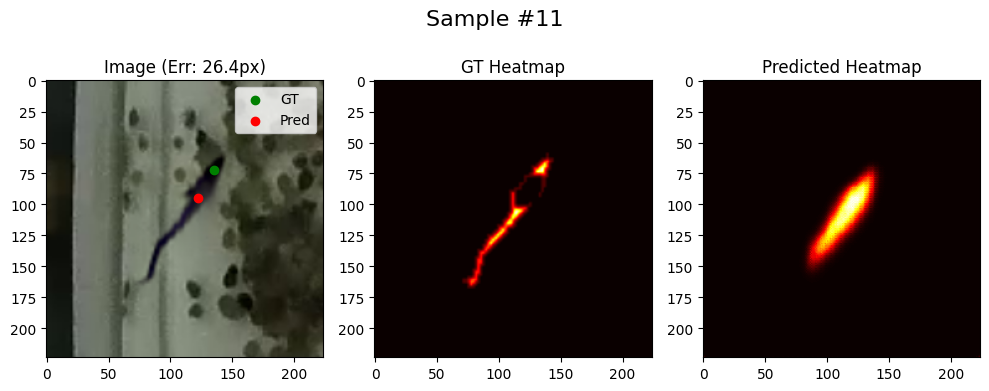

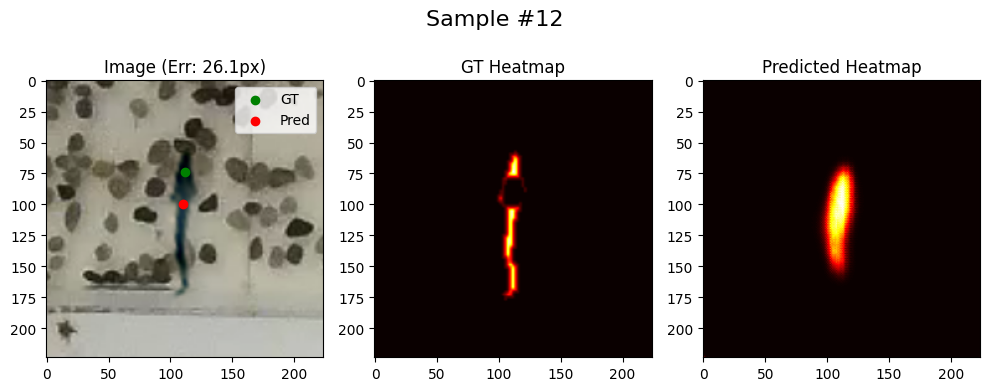

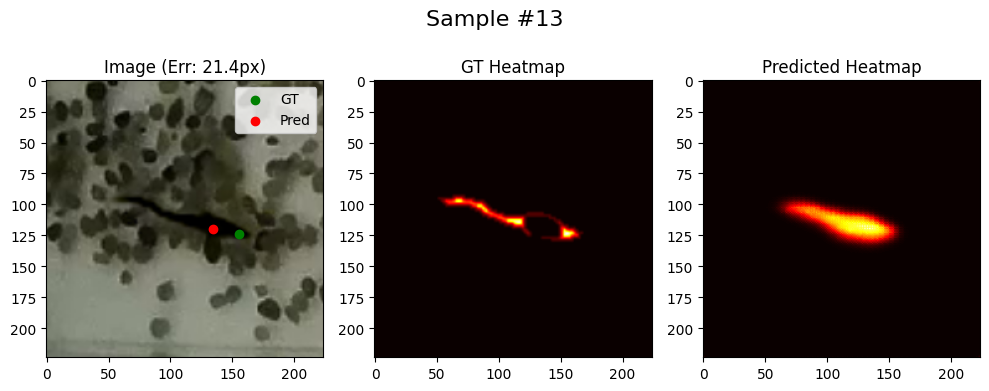

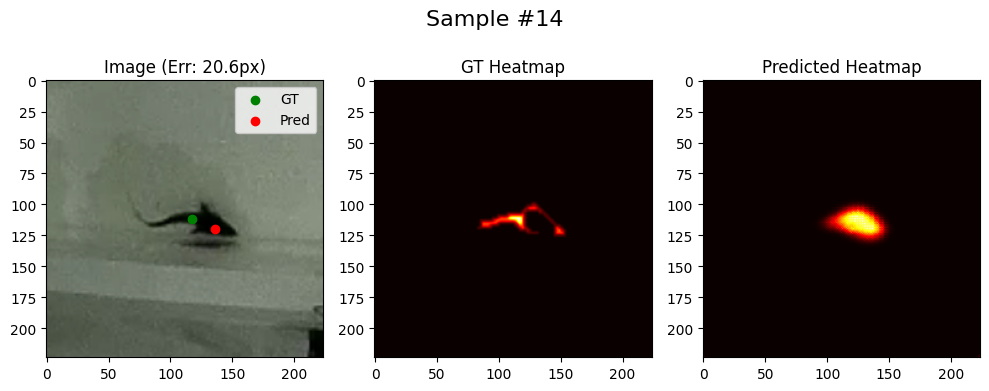

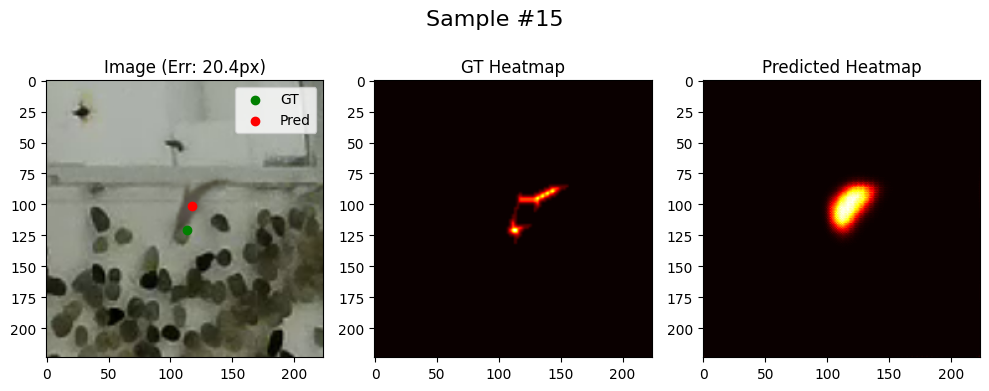

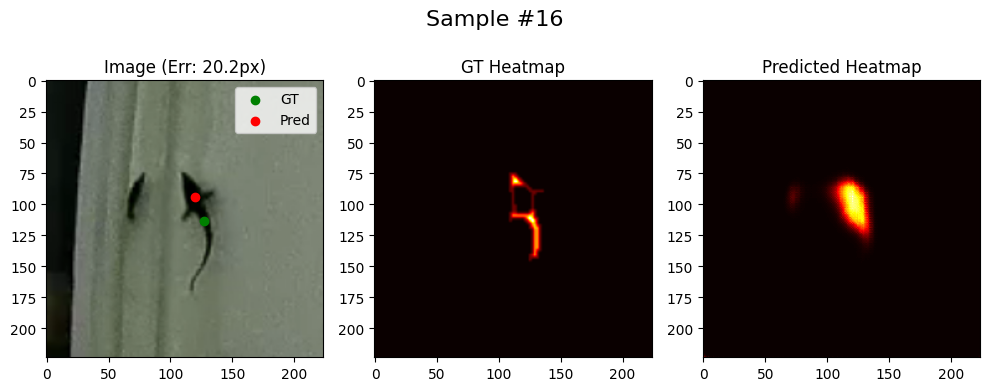

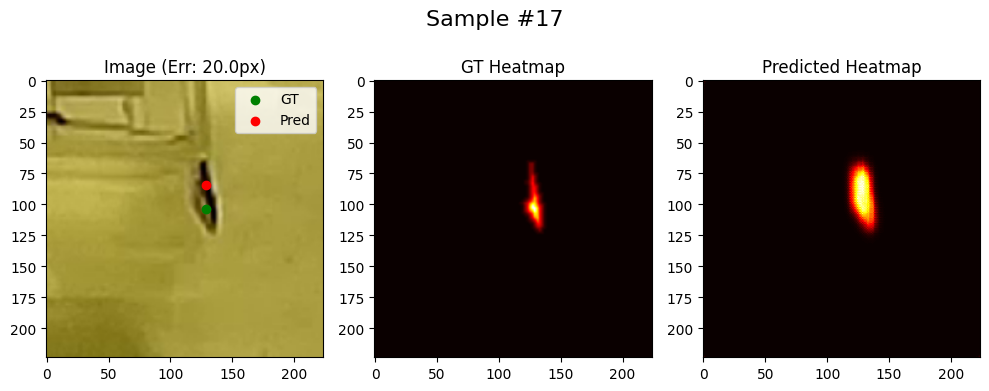

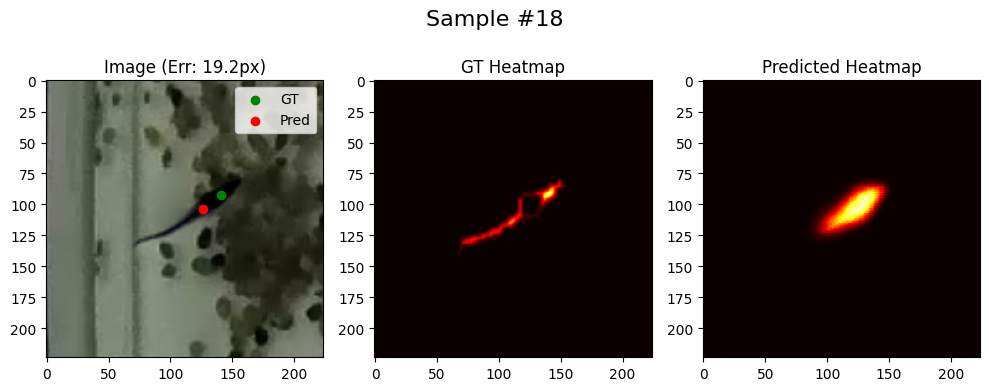

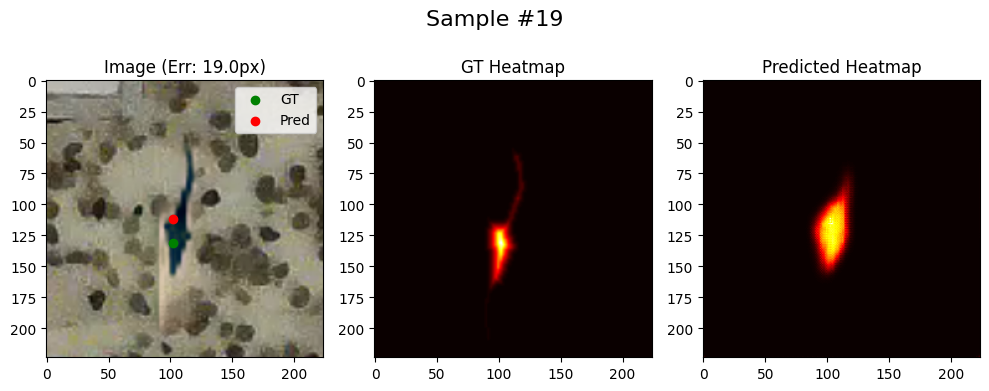

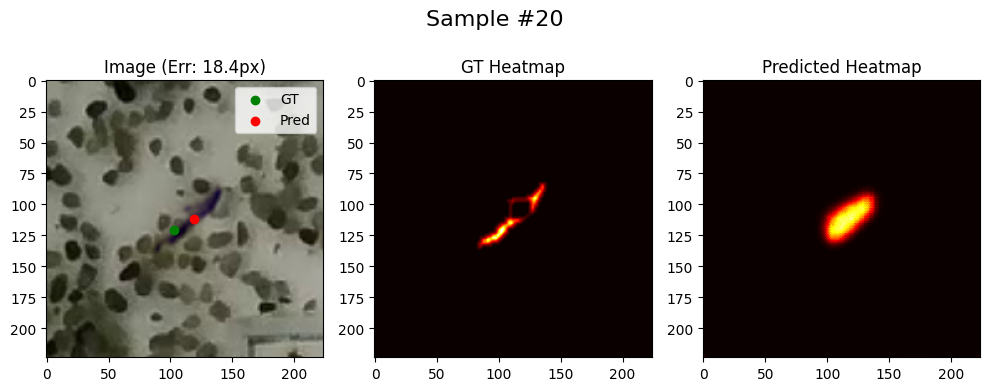

In [29]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT')
    axs[0].scatter([xp], [yp], c='red', label='Pred')
    axs[0].set_title(f'Image (Err: {dist:.1f}px)')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()

# Show top 5 worst predictions
for i in range(10, 20):
    show_sample(results[i], index=i+1)
